# Update state after breakpoint

## Redefine financial advicer graph (from 03_agent.ipynb)

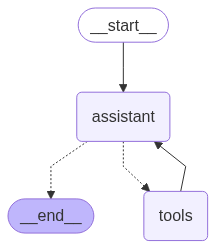

In [1]:
import requests
import yfinance as yf
from pprint import pformat
from langchain_core.tools import Tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


# Defining Tools
##################################################################################

def lookup_stock_symbol(company_name: str) -> str:
    """
    Converts a company name to its stock symbol using a financial API.

    Parameters:
        company_name (str): The full company name (e.g., 'Tesla').

    Returns:
        str: The stock symbol (e.g., 'TSLA') or an error message.
    """
    api_url = "https://www.alphavantage.co/query"
    params = {
        "function": "SYMBOL_SEARCH",
        "keywords": company_name,
        "apikey": "your_alphavantage_api_key"
    }
    
    response = requests.get(api_url, params=params)
    data = response.json()
    
    if "bestMatches" in data and data["bestMatches"]:
        return data["bestMatches"][0]["1. symbol"]
    else:
        return f"Symbol not found for {company_name}."


def fetch_stock_data_raw(stock_symbol: str) -> dict:
    """
    Fetches comprehensive stock data for a given symbol and returns it as a combined dictionary.

    Parameters:
        stock_symbol (str): The stock ticker symbol (e.g., 'TSLA').
        period (str): The period to analyze (e.g., '1mo', '3mo', '1y').

    Returns:
        dict: A dictionary combining general stock info and historical market data.
    """
    period = "1mo"
    try:
        stock = yf.Ticker(stock_symbol)

        # Retrieve general stock info and historical market data
        stock_info = stock.info  # Basic company and stock data
        stock_history = stock.history(period=period).to_dict()  # Historical OHLCV data

        # Combine both into a single dictionary
        combined_data = {
            "stock_symbol": stock_symbol,
            "info": stock_info,
            "history": stock_history
        }

        return pformat(combined_data)

    except Exception as e:
        return {"error": f"Error fetching stock data for {stock_symbol}: {str(e)}"}


# Binding tools to the LLM
##################################################################################

# Create tool bindings with additional attributes
lookup_stock = Tool.from_function(
    func=lookup_stock_symbol,
    name="lookup_stock_symbol",
    description="Converts a company name to its stock symbol using a financial API.",
    return_direct=False  # Return result to be processed by LLM
)

fetch_stock = Tool.from_function(
    func=fetch_stock_data_raw,
    name="fetch_stock_data_raw",
    description="Fetches comprehensive stock data including general info and historical market data for a given stock symbol.",
    return_direct=False
)

toolbox = [lookup_stock, fetch_stock]

# OPENAI_API_KEY environment variable must be set
simple_llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = simple_llm.bind_tools(toolbox)


# Defining Agent's node
##################################################################################

# System message
assistant_system_message = SystemMessage(content=("""
You are a professional financial assistant specializing in stock market analysis and investment strategies. 
Your role is to analyze stock data and provide **clear, decisive recommendations** that users can act on, 
whether they already hold the stock or are considering investing.

You have access to a set of tools that can provide the data you need to analyze stocks effectively. 
Use these tools to gather relevant information such as stock symbols, current prices, historical trends, 
and key financial indicators. Your goal is to leverage these resources efficiently to generate accurate, 
actionable insights for the user.

Your responses should be:
- **Concise and direct**, summarizing only the most critical insights.
- **Actionable**, offering clear guidance on whether to buy, sell, hold, or wait for better opportunities.
- **Context-aware**, considering both current holders and potential investors.
- **Free of speculation**, relying solely on factual data and trends.
- **do not forget** to provide stock name in the report, so it's clear which stock is being recommended.

### Response Format:
1. **Recommendation:** Buy, Sell, Hold, or Wait.
2. **Key Insights:** Highlight critical trends and market factors that influence the decision.
3. **Suggested Next Steps:** What the user should do based on their current position.

If the user does not specify whether they own the stock, provide recommendations for both potential buyers and current holders. Ensure your advice considers valuation, trends, and market sentiment.

Your goal is to help users make informed financial decisions quickly and confidently.
"""))

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([assistant_system_message] + state["messages"])]}


# Defining Graph
##################################################################################
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(toolbox))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Let's set breakpoints before Assistant node

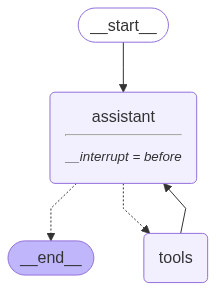

In [2]:
memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Let's run it

In [3]:
# start a new conversation
thread = {"configurable": {"thread_id": "1"}}

# define intiial user request
initial_input = {"messages": HumanMessage(content="Should I invest in Tesla stocks?")}

# run the graph and stream in values mode
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Should I invest in Tesla stocks?


## Get the graph state

In [4]:
from pprint import pprint

state = graph.get_state(thread)
pprint(state)

StateSnapshot(values={'messages': [HumanMessage(content='Should I invest in Tesla stocks?', additional_kwargs={}, response_metadata={}, id='5d95eb0f-4ed9-42b1-a4b2-453d2ca138ba')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07a093-480f-69a6-8000-88db6770bde1'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-08-15T18:54:00.264746+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07a093-480a-6c7e-bfff-cb8f980c004c'}}, tasks=(PregelTask(id='f40d6c3e-18ec-cf66-1216-0eb7d10911e9', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())


## Update graph state (add a new message)

In [5]:
graph.update_state(thread, {"messages": [HumanMessage(content="No sorry, I changed my mind. I would be more interested in Apple stocks!")]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07acef-d6d1-62ce-8001-5b277d349f57'}}

## Let's check the state

In [6]:
messages = graph.get_state(thread).values['messages']
for message in messages:
    message.pretty_print()

================================ Human Message =================================

Should I invest in Tesla stocks?
================================ Human Message =================================

No sorry, I changed my mind. I would be more interested in Apple stocks!


## Resuming the graph

In [7]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No sorry, I changed my mind. I would be more interested in Apple stocks!
================================== Ai Message ==================================
Tool Calls:
  lookup_stock_symbol (call_6BrY4yJxoReElPDND4b5tsZ3)
 Call ID: call_6BrY4yJxoReElPDND4b5tsZ3
  Args:
    __arg1: Apple
================================= Tool Message =================================
Name: lookup_stock_symbol

APLE


## We stopped again on Assistant node, let's resume

In [8]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: lookup_stock_symbol

APLE
================================== Ai Message ==================================
Tool Calls:
  fetch_stock_data_raw (call_FK5yjKtcOlf4OYZGrNZM24LE)
 Call ID: call_FK5yjKtcOlf4OYZGrNZM24LE
  Args:
    __arg1: AAPL
================================= Tool Message =================================
Name: fetch_stock_data_raw

{'history': {'Close': {Timestamp('2025-07-16 00:00:00-0400', tz='America/New_York'): 209.92176818847656,
                       Timestamp('2025-07-17 00:00:00-0400', tz='America/New_York'): 209.78192138671875,
                       Timestamp('2025-07-18 00:00:00-0400', tz='America/New_York'): 210.9405975341797,
                       Timestamp('2025-07-21 00:00:00-0400', tz='America/New_York'): 212.23912048339844,
                       Timestamp('2025-07-22 00:00:00-0400', tz='America/New_York'): 214.15695190429688,
                       Timestamp('2025-07

In [9]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: fetch_stock_data_raw

{'history': {'Close': {Timestamp('2025-07-16 00:00:00-0400', tz='America/New_York'): 209.92176818847656,
                       Timestamp('2025-07-17 00:00:00-0400', tz='America/New_York'): 209.78192138671875,
                       Timestamp('2025-07-18 00:00:00-0400', tz='America/New_York'): 210.9405975341797,
                       Timestamp('2025-07-21 00:00:00-0400', tz='America/New_York'): 212.23912048339844,
                       Timestamp('2025-07-22 00:00:00-0400', tz='America/New_York'): 214.15695190429688,
                       Timestamp('2025-07-23 00:00:00-0400', tz='America/New_York'): 213.9072265625,
                       Timestamp('2025-07-24 00:00:00-0400', tz='America/New_York'): 213.51766967773438,
                       Timestamp('2025-07-25 00:00:00-0400', tz='America/New_York'): 213.63754272460938,
                       Timestamp('2025-07-28 00:00:00-04

# Change graph state in Studio

1) set a break point

2) trigger the update

- Should I invest in Tesla stocks?
- No sorry, I changed my mind. I would be more interested in Apple stocks!

# Updating via API

In [11]:
from langgraph_sdk import get_client

URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

assistants = await client.assistants.search()
assistants

[{'assistant_id': '45d7f46b-abb2-5734-9fb9-b1edc76c6546',
  'graph_id': 'dev_mentor',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'dev_mentor',
  'created_at': '2025-08-15T17:20:59.259433+00:00',
  'updated_at': '2025-08-15T17:20:59.259433+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': 'ae2c32e4-0e45-57db-b449-103064dcb967',
  'graph_id': 'directive_memory_bot',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'directive_memory_bot',
  'created_at': '2025-08-15T17:20:59.156435+00:00',
  'updated_at': '2025-08-15T17:20:59.156435+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '89e77aa6-c452-5416-bd83-721b80077ae5',
  'graph_id': 'chatbot_long_term_memory',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'chatbot_long_term_memory',
  'created_at': '2025-08-15T17:20:59.046553+00:00',
  'updated_at': '2025-08-15T17:20:59.046553+00:00',
  'version'

## Start a chat with a breakpoint before "Assistant" node

In [12]:
from langchain_core.messages import convert_to_messages

thread = await client.threads.create()
input_message = HumanMessage(content="Should I invest in Tesla stocks?")

async for event in client.runs.stream(
            thread["thread_id"], 
            assistant_id="b7480eb0-6390-53a5-9bc4-29bf27cbd1c4", 
            input={"messages": [input_message]}, 
            stream_mode="values",
            interrupt_before=["assistant"],
):
    messages = event.data.get('messages', None)
    if messages:
        print(convert_to_messages(messages)[-1])

content='Should I invest in Tesla stocks?' additional_kwargs={} response_metadata={} id='8ab49170-e22b-432e-8983-7f2f645bcda7'


## Get the current state

In [13]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'messages': [{'content': 'Should I invest in Tesla stocks?',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '8ab49170-e22b-432e-8983-7f2f645bcda7',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': '98b0965f-dab7-9d30-7910-8719792a3ca5',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'host': '127.0.0.1:2024',
  'accept-encoding': 'gzip, deflate, zstd',
  'connection': 'keep-alive',
  'user-agent': 'langgraph-sdk-py/0.2.0',
  'x-api-key': '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',
  'content-length': '330',
  'content-type': 'application/json',
  'accept': 'text/event-stream',
  'cache-control': 'no-store',
  'x-request-id': 'e5900755-6f15-4a81-bf9c-3eff69bb0278',
  'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions

## Let's grab the latest message and update it

In [14]:
last_message = current_state['values']['messages'][-1]
last_message

{'content': 'Should I invest in Tesla stocks?',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '8ab49170-e22b-432e-8983-7f2f645bcda7',
 'example': False}

### Replace the message content keeping the `id` the same

In [15]:
last_message['content'] = "No sorry, I changed my mind. I would be more interested in Apple stocks!"
last_message

{'content': 'No sorry, I changed my mind. I would be more interested in Apple stocks!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '8ab49170-e22b-432e-8983-7f2f645bcda7',
 'example': False}

## Update the state (with message replacement)

In [16]:
await client.threads.update_state(thread['thread_id'], {"messages": last_message})

{'checkpoint': {'thread_id': '6663828d-8f1e-499b-b62f-c83d79ec92e4',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07acfd-3039-6a11-8001-58b37fcfaa5b'},
 'configurable': {'thread_id': '6663828d-8f1e-499b-b62f-c83d79ec92e4',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07acfd-3039-6a11-8001-58b37fcfaa5b'},
 'checkpoint_id': '1f07acfd-3039-6a11-8001-58b37fcfaa5b'}

## Resume the graph

In [17]:
async for event in client.runs.stream(
            thread["thread_id"], 
            assistant_id="b7480eb0-6390-53a5-9bc4-29bf27cbd1c4", 
            input=None, 
            stream_mode="values",
            interrupt_before=["assistant"],
):
    messages = event.data.get('messages', None)
    if messages:
        print(f"\n\n{convert_to_messages(messages)[-1]}")



content='No sorry, I changed my mind. I would be more interested in Apple stocks!' additional_kwargs={} response_metadata={} id='8ab49170-e22b-432e-8983-7f2f645bcda7'


content='' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 402, 'output_tokens': 17, 'total_tokens': 419, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'tool_calls': [{'id': 'call_j5FfyWX4hPZa9lFMZq3vA8iZ', 'function': {'arguments': '{"__arg1":"Apple"}', 'name': 'lookup_stock_symbol'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 402, 'total_tokens': 419, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C5G2

## A node with human feedback

A simple way to use human feedback is to create a human_feedback node that collects user input. This helps us gather feedback at a specific point in our graph.

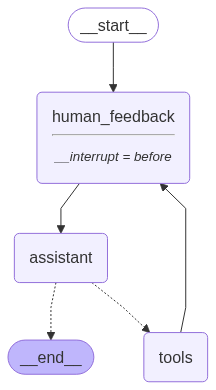

In [18]:
def human_feedback(state: MessagesState):
    pass


# Defining Graph
##################################################################################
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(toolbox))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Update state as user_feedback node

In [20]:
thread = {"configurable": {"thread_id": "2"}}

initial_input = {"messages": "Should I invest in Tesla stocks?"}


for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
user_input = input("Update the state:")

graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Should I invest in Tesla stocks?


Update the state: I change my mind, should I invest in APPLE?


================================ Human Message =================================

I change my mind, should I invest in APPLE?
================================== Ai Message ==================================
Tool Calls:
  lookup_stock_symbol (call_uHcdrb0hN7XYT9boWFpC9Lzh)
 Call ID: call_uHcdrb0hN7XYT9boWFpC9Lzh
  Args:
    __arg1: Apple
  lookup_stock_symbol (call_WR1Qu2933RjgptWZMh6cmwcV)
 Call ID: call_WR1Qu2933RjgptWZMh6cmwcV
  Args:
    __arg1: Tesla
================================= Tool Message =================================
Name: lookup_stock_symbol

TSLA
